In [0]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os


from pathlib import Path
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

1.14.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip  -q "/content/drive/My Drive/leapGestRecog.zip"

replace leapGestRecog/00/01_palm/frame_00_01_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
!ls "/content/drive/My Drive"

'Anyfile Notepad Files'      'Colab Notebooks'		    lec43.pdf
'Anyfile Notepad Files (1)'   dataset_sept11_oct3.csv.rar   pics
 Classroom		      leapGestRecog.zip


In [0]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk('leapGestRecog/', topdown=False):
  #print(root)
  #print(dirs)
  #print(files)
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

20000


In [0]:
!ls

drive  handrecognition_model.h5  leapGestRecog	sample_data


In [0]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

In [0]:
imagepaths[0]

'leapGestRecog/00/01_palm/frame_00_01_0021.png'

(240, 640)


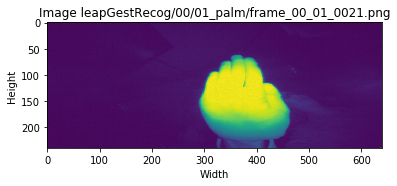

In [0]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [0]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("/")[2]
  label = int(category.split("_")[0][1]) #  we need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20000
Labels loaded:  20000
1 leapGestRecog/00/01_palm/frame_00_01_0021.png


In [0]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [0]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [0]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [0]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [0]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Train on 14000 samples, validate on 6000 samples
Epoch 1/5
 - 32s - loss: 14.4654 - acc: 0.0999 - val_loss: 14.5439 - val_acc: 0.0977
Epoch 2/5
 - 31s - loss: 14.4902 - acc: 0.1010 - val_loss: 14.5439 - val_acc: 0.0977
Epoch 3/5
 - 31s - loss: 14.4902 - acc: 0.1010 - val_loss: 14.5439 - val_acc: 0.0977
Epoch 4/5
 - 31s - loss: 14.4902 - acc: 0.1010 - val_loss: 14.5439 - val_acc: 0.0977
Epoch 5/5
 - 31s - loss: 14.4902 - acc: 0.1010 - val_loss: 14.5439 - val_acc: 0.0977


In [0]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

6000/6000 [==============================] - 5s 762us/step
Test accuracy: 10.08%


In [0]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [0]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(0, 8)

In [0]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

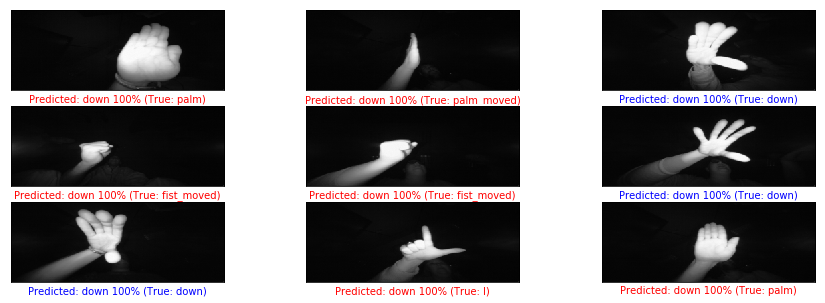

In [0]:
validate_9_images(predictions, y_test, X_test)

In [0]:

y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [0]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,596,0,0,0,0,0,0,0,0,0
Actual Palm (H),605,0,0,0,0,0,0,0,0,0
Actual L,621,0,0,0,0,0,0,0,0,0
Actual Fist (H),600,0,0,0,0,0,0,0,0,0
Actual Fist (V),604,0,0,0,0,0,0,0,0,0
Actual Thumbs up,611,0,0,0,0,0,0,0,0,0
Actual Index,568,0,0,0,0,0,0,0,0,0
Actual OK,586,0,0,0,0,0,0,0,0,0
Actual Palm (V),591,0,0,0,0,0,0,0,0,0
Actual C,618,0,0,0,0,0,0,0,0,0
